In [1]:
using StatsBase

In [2]:
include("betaSkeletons.jl")
#include("betaSkeletonNoDistributed.jl") # for small dimensions you must use this script. 

plotDelaunay (generic function with 1 method)

In [3]:
using HDF5, JLD, Test, ProgressMeter, Pkg

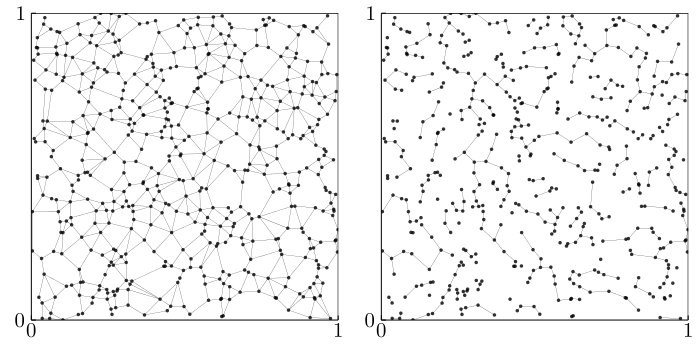

In [4]:
puntos, luna, circulo = betaSkeleton(1.2, 500)
p1 = plotBetaSkeleton(puntos, luna)
p2 = plotBetaSkeleton(puntos, circulo)
plot(p1, p2, layout = (1, 2), legend=false, size = (700, 350))

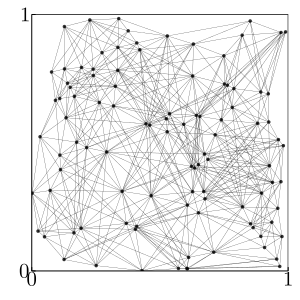

In [5]:
puntos, adeacencia = betaSkeleton(0.58, 100)
plotBetaSkeleton(puntos, adeacencia)

In [6]:
@time nodos, lunes = betaSkeleton(0.2, 1000);

  3.812516 seconds (2.07 k allocations: 7.847 MiB)


In [7]:
@time nodos, lunes = betaSkeleton(0.2, 1000);

  3.716466 seconds (2.18 k allocations: 7.851 MiB, 0.30% gc time)


In [8]:
function spectra_eigenfunctions(dim_base, beta, numOfnodes, iteraciones)
    lowerB = Int64(ceil(numOfnodes/4))
    upperB = Int64(ceil(numOfnodes*3/4))
    size_s = upperB - lowerB
    file = h5open("lDim$(numOfnodes)beta$(beta).h5", "w")
    spacingslunes = d_create(file,"spacingslunes",datatype(Float64), dataspace(size_s, 1, iteraciones))
    iprqss = d_create(file,"iprqss",datatype(Float64), dataspace(size_s, 81, iteraciones))
    #valscircles = d_create(fm,"valsCircles",datatype(Float64), dataspace(size_s, 1, iteraciones))  
    for i in 1:iteraciones
        nodos, lunes, circulos = betaSkeleton(beta, numOfnodes)
        slunes = Symmetric(lunes)
        #scirculos = Symmetric(circulos)
        valsLune, vecsLune = eigen(slunes)
        #valsCirculo, vecsCirculo = eigen(scirculos)
        
        silune = valsLune[lowerB:upperB - 1]
        sflune = valsLune[lowerB + 1:upperB]
        spacingslunes[:, :, i] = sflune .- silune # energy level spacings
        cutvecs = vecsLune[:,lowerB:upperB-1]
        
        for (indx, qi) in enumerate(-4:0.1:4)
            eigenqi = abs.(cutvecs).^(2*qi)
            if qi == 1.0
                iprqss[:,indx,i] = -sumColsNaN(eigenqi.*log.(eigenqi))
            else
                iprqss[:,indx,i] = sumColsInf(eigenqi)
            end
        end
    end
    flush(file)
    close(file)
end

spectra_eigenfunctions (generic function with 1 method)

In [9]:
#spectra_eigenfunctions(1.0, 1.0, 500, 2000)

In [10]:
#spectra_eigenfunctions(1.0, 1.0, 50, 20000)

In [11]:
#spectra_eigenfunctions(1.0, 1.0, 100, 10000)

In [12]:
#spectra_eigenfunctions(1.0, 1.0, 200, 5000)

In [13]:
#spectra_eigenfunctions(1.0, 1.0, 400, 2500)

In [14]:
#spectra_eigenfunctions(1.0, 1.0, 800, 1250)

In [15]:
#spectra_eigenfunctions(1.0, 1.0, 1600, 625)

In [16]:
#spectra_eigenfunctions(1.0, 1.0, 3200, 313)

In [17]:
#spectra_eigenfunctions(1.0, 1.0, 1000, 1000)

In [18]:
#spectra_eigenfunctions(1.0, 1.0, 2000, 500)

In [19]:
#spectra_eigenfunctions(1.0, 1.0, 4000, 250)

In [20]:
#50, 20000, 100, 10000, 200, 5000, 400, 2500, 800, 1250, 1600, 625

# Load files 

In [21]:
function pshist(filename, luneCircle)
    testbin = collect(range(0.0, 5.0, length=128))
    push!(testbin, 5.0 + testbin[2])
    
    fileattr = h5open(filename,"r")
    dimensiones = size(readmmap(fileattr[luneCircle]))    
    sizels = dimensiones[1]
    itera = dimensiones[3]
    close(fileattr)
    
    data = h5read(filename, luneCircle, (:,:,1))
    lsdval = reshape(data./mean(data), (sizels,))
    lsdval[lsdval .> 5.0] .= 5.01
    hist1 = fit(Histogram, lsdval, testbin)
    
    for i in 2:itera
        dataentryi = h5read(filename, luneCircle, (:,:,i))
        lsdval = reshape(dataentryi./mean(dataentryi), (sizels,))
        lsdval[lsdval .> 5.0] .= 5.01
        histi = fit(Histogram, lsdval, testbin)
        merge!(hist1, histi)
    end
    hist1
end

pshist (generic function with 1 method)

In [23]:
hist50 = pshist("lDim50beta1.0.h5", "spacingslunes")

In [8]:
hist100 = pshist("lDim100beta1.0.h5", "spacingslunes")
hist200 = pshist("lDim200beta1.0.h5", "spacingslunes")
hist400 = pshist("lDim400beta1.0.h5", "spacingslunes")
hist500 = pshist("lDim500beta1.0.h5", "spacingslunes")
hist800 = pshist("lDim800beta1.0.h5", "spacingslunes")
hist1000 = pshist("lDim1000beta1.0.h5", "spacingslunes")
hist1600 = pshist("lDim1600beta1.0.h5", "spacingslunes")
hist2000 = pshist("lDim2000beta1.0.h5", "spacingslunes")
hist3200 = pshist("lDim3200beta1.0.h5", "spacingslunes")
hist4000 = pshist("lDim4000beta1.0.h5", "spacingslunes");

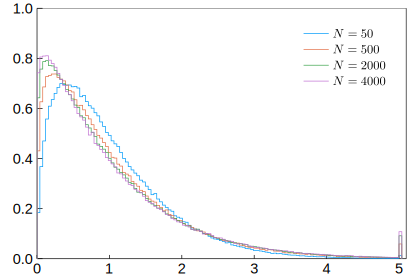

In [36]:
plot(normalize(hist50, mode = :pdf), seriestype=:steps, label = L"N = 50", legend = true,
    legendfontsize = 12, fg_legend = :white,
    grid = false, axis = :on, framestyle=:box, xlim =(0,5.1), ylim=(0,1),
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    dpi=70, size = (600,400))
#plot!(normalize(hist2, mode = :pdf), seriestype=:steps, legend = false)
#plot!(normalize(hist200, mode = :pdf), seriestype=:steps, label = L"N=200")
#plot!(normalize(hist4, mode = :pdf), seriestype=:steps, legend = false)
plot!(normalize(hist500, mode = :pdf), seriestype=:steps, label = L"N=500")
#plot!(normalize(hist6, mode = :pdf), seriestype=:steps, label = L"N=1600")
#plot!(normalize(hist2000, mode = :pdf), seriestype=:steps, label = L"N=2000")
plot!(normalize(hist2000, mode = :pdf), seriestype=:steps, label = L"N=2000")
#plot!(normalize(hist1, mode = :probability), seriestype=:steps)
plot!(normalize(hist4000, mode = :pdf), seriestype=:steps, label = L"N=4000")

In [61]:
#spectra_eigenfunctions(1.0, 10.0, 100, 10000)

In [37]:
hist100b10 = pshist("lDim100beta10.0.h5", "spacingslunes")

Histogram{Int64,1,Tuple{Array{Float64,1}}}
edges:
  [0.0, 0.0393701, 0.0787402, 0.11811, 0.15748, 0.19685, 0.23622, 0.275591, 0.314961, 0.354331  …  4.68504, 4.72441, 4.76378, 4.80315, 4.84252, 4.88189, 4.92126, 4.96063, 5.0, 5.03937]
weights: [18864, 17939, 17284, 16677, 16125, 15461, 14895, 14450, 13848, 13475  …  156, 157, 132, 152, 139, 133, 111, 118, 117, 2633]
closed: left
isdensity: false

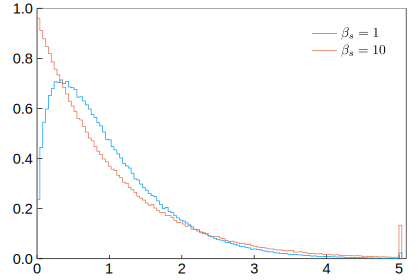

In [38]:
plot(normalize(hist100, mode = :pdf), seriestype=:steps, label = L"\beta_s= 1", legend = true,
    legendfontsize = 13, fg_legend = :white,
    grid = false, axis = :on, framestyle=:box, xlim =(0,5.1), ylim=(0,1),
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    dpi=70, size = (600,400))
plot!(normalize(hist100b10, mode = :pdf), seriestype=:steps, label = L"\beta_s=10")

In [39]:
function spectra_eigenfunctions2(dim_base, beta, numOfnodes, iteraciones)
    lowerB = Int64(ceil(numOfnodes/4))
    upperB = Int64(ceil(numOfnodes*3/4))
    size_s = upperB - lowerB
    file = h5open("lDim$(numOfnodes)beta$(beta).h5", "w")
    spacingslunes = d_create(file,"spacingslunes",datatype(Float64), dataspace(size_s, 1, iteraciones))
    iprqss = d_create(file,"iprqss",datatype(Float64), dataspace(size_s, 81, iteraciones))
    #valscircles = d_create(fm,"valsCircles",datatype(Float64), dataspace(size_s, 1, iteraciones))  
    for i in 1:iteraciones
        nodos, adeacencia = betaSkeleton(beta, numOfnodes)
        #nodos, lunes, circulos = betaSkeleton(beta, numOfnodes)
        slunes = Symmetric(adeacencia)
        #scirculos = Symmetric(circulos)
        valsLune, vecsLune = eigen(slunes)
        #valsCirculo, vecsCirculo = eigen(scirculos)
        
        silune = valsLune[lowerB:upperB - 1]
        sflune = valsLune[lowerB + 1:upperB]
        spacingslunes[:, :, i] = sflune .- silune # energy level spacings
        cutvecs = vecsLune[:,lowerB:upperB-1]
        
        for (indx, qi) in enumerate(-4:0.1:4)
            eigenqi = abs.(cutvecs).^(2*qi)
            if qi == 1.0
                iprqss[:,indx,i] = -sumColsNaN(eigenqi.*log.(eigenqi))
            else
                iprqss[:,indx,i] = sumColsInf(eigenqi)
            end
        end
    end
    flush(file)
    close(file)
end

spectra_eigenfunctions2 (generic function with 1 method)

In [40]:
#spectra_eigenfunctions2(1.0, 0.1, 100, 10000)

In [41]:
hist100bdot1 = pshist("lDim100beta0.1.h5", "spacingslunes")

Histogram{Int64,1,Tuple{Array{Float64,1}}}
edges:
  [0.0, 0.0393701, 0.0787402, 0.11811, 0.15748, 0.19685, 0.23622, 0.275591, 0.314961, 0.354331  …  4.68504, 4.72441, 4.76378, 4.80315, 4.84252, 4.88189, 4.92126, 4.96063, 5.0, 5.03937]
weights: [639, 1944, 3136, 4398, 5648, 6769, 7871, 8727, 9900, 10496  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
closed: left
isdensity: false

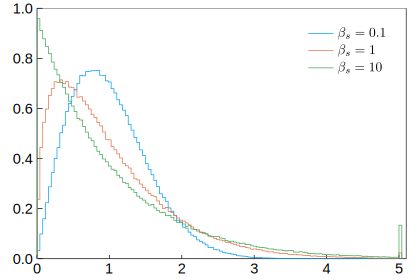

In [43]:
plot(normalize(hist100bdot1, mode = :pdf), seriestype=:steps, label = L"\beta_s= 0.1", legend = true,
    legendfontsize = 13, fg_legend = :white,
    grid = false, axis = :on, framestyle=:box, xlim =(0,5.1), ylim=(0,1),
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    dpi=70, size = (600,400))
plot!(normalize(hist100, mode = :pdf), seriestype=:steps, label = L"\beta_s=1")
plot!(normalize(hist100b10, mode = :pdf), seriestype=:steps, label = L"\beta_s=10")


In [44]:
#spectra_eigenfunctions2(1.0, 0.9, 100, 10000)

In [45]:
hist100dot9 = pshist("lDim100beta0.9.h5", "spacingslunes")

Histogram{Int64,1,Tuple{Array{Float64,1}}}
edges:
  [0.0, 0.0393701, 0.0787402, 0.11811, 0.15748, 0.19685, 0.23622, 0.275591, 0.314961, 0.354331  …  4.68504, 4.72441, 4.76378, 4.80315, 4.84252, 4.88189, 4.92126, 4.96063, 5.0, 5.03937]
weights: [1179, 3337, 5383, 6976, 8501, 9659, 10776, 11733, 12584, 13181  …  13, 11, 9, 6, 8, 10, 8, 4, 4, 63]
closed: left
isdensity: false

In [9]:
using SpecialFunctions

In [10]:
function ps(s, beta)
    tp = (beta .+ 1).*gamma.((beta .+ 2)./(beta .+1)).^(beta .+ 1).*s.^beta
    texp = exp.(-gamma.((beta .+ 2)./(beta .+ 1)).^(beta .+ 1).*s.^(beta .+ 1))
    tp.*texp
end

ps (generic function with 1 method)

In [11]:
s = LinRange(0,5, 100)

100-element LinRange{Float64}:
 0.0,0.0505051,0.10101,0.151515,0.20202,…,4.79798,4.84848,4.89899,4.94949,5.0

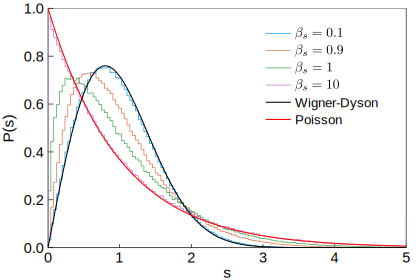

In [51]:
plot(normalize(hist100bdot1, mode = :pdf), seriestype=:steps, label = L"\beta_s= 0.1", 
    legend = true,legendfontsize = 13, fg_legend = :white, 
    xlab = "s", ylab = "P(s)", guidefont= font(15, "sans-serif"),
    grid = false, axis = :on, framestyle=:box, xlim =(0,5.0), ylim=(0,1),
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    dpi=70, size = (600,400))
plot!(normalize(hist100dot9, mode = :pdf), seriestype=:steps, label = L"\beta_s=0.9")
plot!(normalize(hist100, mode = :pdf), seriestype=:steps, label = L"\beta_s=1")
plot!(normalize(hist100b10, mode = :pdf), seriestype=:steps, label = L"\beta_s=10")
plot!(s, ps(s,1.0), lw = 1.5, c =:black, label = "Wigner-Dyson")
plot!(s, ps(s,0.0), lw = 1.5, c =:red,label = "Poisson")


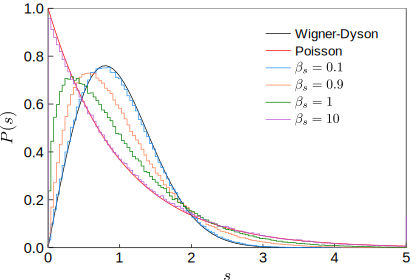

In [101]:
p = plot(s, ps(s,1.0), lw = 1.0, c =:black, label = "Wigner-Dyson",
    legend = true,legendfontsize = 13, fg_legend = :white, 
    xlab = L"s", ylab = L"P(s)", guidefont= font(16, "sans-serif"),
    grid = false, axis = :on, framestyle=:box, xlim =(0,5.0), ylim=(0,1),
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    dpi=70, size = (600,400))
plot!(s, ps(s,0.0), lw = 1.0, c =:red,label = "Poisson")

plot!(normalize(hist100bdot1, mode = :pdf), seriestype=:steps, 
    c =:dodgerblue, label = L"\beta_s= 0.1")
plot!(normalize(hist100dot9, mode = :pdf), seriestype=:steps, 
    c =:coral, label = L"\beta_s=0.9")
plot!(normalize(hist100, mode = :pdf), seriestype=:steps, 
    c =:green, label = L"\beta_s=1")
plot!(normalize(hist100b10, mode = :pdf), seriestype=:steps, 
    c =:mediumorchid, label = L"\beta_s=10")
#savefig("psSkeletons.pdf")

In [12]:
using LsqFit

In [105]:
datafit = normalize(hist100dot9, mode = :pdf)
binsinData = collect(range(0.0, 5.0, length=128))
xs = (binsinData[2:end] .+ binsinData[1:end-1])./2
ys = datafit.weights[1:end-1];

In [13]:
function findbeta(fn, xdata, ydata)
    fitres = curve_fit(fn, xdata, ydata, [0.5], lower=[0.0], upper=[1.0])
    fitres.param[1], standard_error(fitres)[1]
end

findbeta (generic function with 1 method)

In [107]:
valbeta, sigmaerror = findbeta(ps, xs, ys)

(0.619135904505545, 0.009314464249792835)

In [109]:
datafit = normalize(hist100bdot1, mode = :pdf)
ys = datafit.weights[1:end-1]
valbeta, sigmaerror = findbeta(ps, xs, ys)

(0.9538427831164866, 0.0021168587861755046)

In [110]:
datafit = normalize(hist100, mode = :pdf)
ys = datafit.weights[1:end-1]
valbeta, sigmaerror = findbeta(ps, xs, ys)

(0.3169746377524532, 0.005089257103266658)

In [111]:
datafit = normalize(hist100b10, mode = :pdf)
ys = datafit.weights[1:end-1]
valbeta, sigmaerror = findbeta(ps, xs, ys)

(0.013474391308401697, 0.0010724724943116262)

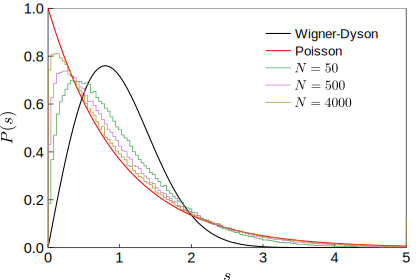

In [69]:
p2 = plot(s, ps(s,1.0), lw = 1.5, c =:black, label = "Wigner-Dyson",
    legend = true,legendfontsize = 13, fg_legend = :white, 
    xlab = L"s", ylab = L"P(s)", guidefont= font(16, "sans-serif"),
    grid = false, axis = :on, framestyle=:box, xlim =(0,5.0), ylim=(0,1),
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    dpi=70, size = (600,400))
plot!(s, ps(s,0.0), lw = 1.5, c =:red,label = "Poisson")

plot!(normalize(hist50, mode = :pdf), seriestype=:steps, label = L"N = 50")
#plot!(normalize(hist2, mode = :pdf), seriestype=:steps, legend = false)
#plot!(normalize(hist200, mode = :pdf), seriestype=:steps, label = L"N=200")
#plot!(normalize(hist4, mode = :pdf), seriestype=:steps, legend = false)
plot!(normalize(hist500, mode = :pdf), seriestype=:steps, label = L"N=500")
#plot!(normalize(hist6, mode = :pdf), seriestype=:steps, label = L"N=1600")
#plot!(normalize(hist2000, mode = :pdf), seriestype=:steps, label = L"N=2000")
#plot!(normalize(hist2000, mode = :pdf), seriestype=:steps, label = L"N=2000")
#plot!(normalize(hist1, mode = :probability), seriestype=:steps)
plot!(normalize(hist4000, mode = :pdf), seriestype=:steps, label = L"N=4000")

### Just for eigenvalues and $0<\beta_s < \infty$

In [16]:
function eigen_spectra(dim_base, beta, numOfnodes, iteraciones)
    lowerB = Int64(ceil(numOfnodes/4))
    upperB = Int64(ceil(numOfnodes*3/4))
    size_s = upperB - lowerB
    file = h5open("spectra$(numOfnodes)b$(beta).h5", "w")
    spacingslunes = d_create(file,"spacingslunes",datatype(Float64), dataspace(size_s, 1, iteraciones))
    valscircles = d_create(file,"spacingsCircles",datatype(Float64), dataspace(size_s, 1, iteraciones))  
    for i in 1:iteraciones
        if beta > 1.0
            nodos, lunes, circulos = betaSkeleton(beta, numOfnodes)
            slunes = Symmetric(lunes)
            scirculos = Symmetric(circulos)
            valsLune= eigvals(slunes)
            valsCirculo = eigvals(scirculos)
            silune = valsLune[lowerB:upperB - 1]
            sflune = valsLune[lowerB + 1:upperB]
            sicircle = valsCirculo[lowerB:upperB - 1]
            sfcircle = valsCirculo[lowerB + 1:upperB]
            spacingslunes[:, :, i] = sflune .- silune # energy level spacings
            valscircles[:, :, i] = sfcircle .- sicircle
        elseif beta <= 1.0
            nodos, lunes = betaSkeleton(beta, numOfnodes)
            slunes = Symmetric(lunes)
            valsLune= eigvals(slunes)
            silune = valsLune[lowerB:upperB - 1]
            sflune = valsLune[lowerB + 1:upperB]
            spacingslunes[:, :, i] = sflune .- silune  
        end
    end
    flush(file)
    close(file)
end

eigen_spectra (generic function with 1 method)

In [19]:
5*100000

500000

In [20]:
@time eigen_spectra(1.0, 1.0, 35, 10)

  0.098518 seconds (183.11 k allocations: 52.318 MiB, 15.16% gc time)


In [21]:
eigen_spectra(1.0, 1.0, 10, 100000)

In [78]:
# dim_base, beta, numOfnodes, iteraciones
#eigen_spectra(1.0, 1.0, 10000, 100)

In [115]:
#eigen_spectra(1.0, 0.001, 100, 10000)

In [119]:
#eigen_spectra(1.0, 0.0001, 100, 10000)

In [14]:
hist10 = pshist("spectra10b1.0.h5", "spacingslunes")

Histogram{Int64,1,Tuple{Array{Float64,1}}}
edges:
  [0.0, 0.0393701, 0.0787402, 0.11811, 0.15748, 0.19685, 0.23622, 0.275591, 0.314961, 0.354331  …  4.68504, 4.72441, 4.76378, 4.80315, 4.84252, 4.88189, 4.92126, 4.96063, 5.0, 5.03937]
weights: [1930, 4305, 6012, 7341, 8377, 9569, 10212, 10901, 11472, 12002  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
closed: left
isdensity: false

In [15]:
hist10000 = pshist("spectra10000b1.0.h5", "spacingslunes")

Histogram{Int64,1,Tuple{Array{Float64,1}}}
edges:
  [0.0, 0.0393701, 0.0787402, 0.11811, 0.15748, 0.19685, 0.23622, 0.275591, 0.314961, 0.354331  …  4.68504, 4.72441, 4.76378, 4.80315, 4.84252, 4.88189, 4.92126, 4.96063, 5.0, 5.03937]
weights: [16368, 17056, 16693, 16251, 15907, 15419, 14836, 14561, 13992, 13646  …  177, 151, 156, 150, 125, 143, 129, 125, 100, 2506]
closed: left
isdensity: false

In [18]:
hist100bdot001 = pshist("spectra100b0.001.h5", "spacingslunes")

Histogram{Int64,1,Tuple{Array{Float64,1}}}
edges:
  [0.0, 0.0393701, 0.0787402, 0.11811, 0.15748, 0.19685, 0.23622, 0.275591, 0.314961, 0.354331  …  4.68504, 4.72441, 4.76378, 4.80315, 4.84252, 4.88189, 4.92126, 4.96063, 5.0, 5.03937]
weights: [620, 1956, 3089, 4514, 5454, 6643, 7718, 8852, 9675, 10580  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
closed: left
isdensity: false

In [19]:
hist100bdot0001 = pshist("spectra100b0.0001.h5", "spacingslunes")

Histogram{Int64,1,Tuple{Array{Float64,1}}}
edges:
  [0.0, 0.0393701, 0.0787402, 0.11811, 0.15748, 0.19685, 0.23622, 0.275591, 0.314961, 0.354331  …  4.68504, 4.72441, 4.76378, 4.80315, 4.84252, 4.88189, 4.92126, 4.96063, 5.0, 5.03937]
weights: [673, 1877, 3119, 4441, 5508, 6700, 7795, 8921, 9726, 10571  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
closed: left
isdensity: false

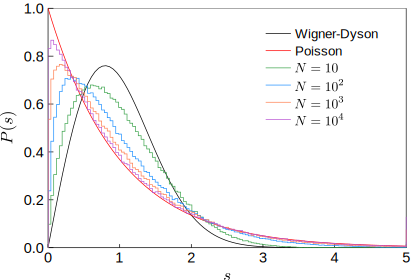

In [27]:
p2 = Plots.plot(s, ps(s,1.0), lw = 1.0, c =:black, label = "Wigner-Dyson",
    legend = true,legendfontsize = 13, fg_legend = :white, 
    xlab = L"s", ylab = L"P(s)", guidefont= font(16, "sans-serif"),
    grid = false, axis = :on, framestyle=:box, xlim =(0,5.0), ylim=(0,1),
    xtickfont = font(14, "sans-serif"), ytickfont = font(14, "sans-serif"),
    dpi=70, size = (600,400))
Plots.plot!(s, ps(s,0.0), lw = 1.0, c =:red,label = "Poisson")
Plots.plot!(normalize(hist10, mode = :pdf),  seriestype=:steps,  label = L"N = 10")
Plots.plot!(normalize(hist100, mode = :pdf),  seriestype=:steps, c =:dodgerblue,  label = L"N = 10^2")
Plots.plot!(normalize(hist1000, mode = :pdf), seriestype=:steps, c =:coral, label = L"N=10^3")
Plots.plot!(normalize(hist10000, mode = :pdf), seriestype=:steps, c =:mediumorchid, label = L"N=10^4")
#Plots.savefig("psSkeletonsBigN.pdf")

In [31]:
binsinData = collect(range(0.0, 5.0, length=128))
xs = (binsinData[2:end] .+ binsinData[1:end-1])./2;

In [32]:
datafit = normalize(hist1000, mode = :pdf)
ys = datafit.weights[1:end-1]
valbeta, sigmaerror = findbeta(ps, xs, ys)

(0.145586064567557, 0.00248157510987608)

In [59]:
datafit = normalize(hist4000, mode = :pdf)
ys = datafit.weights[1:end-1]
valbeta, sigmaerror = findbeta(ps, xs, ys)

(0.07640331501662563, 0.0010897309642621737)

In [33]:
datafit = normalize(hist10000, mode = :pdf)
ys = datafit.weights[1:end-1]
valbeta, sigmaerror = findbeta(ps, xs, ys)

(0.046823005876112024, 0.0007528111683064951)

In [118]:
datafit = normalize(hist100bdot001, mode = :pdf)
ys = datafit.weights[1:end-1]
valbeta, sigmaerror = findbeta(ps, xs, ys)

(0.9612149855661708, 0.002352597643804892)

In [121]:
datafit = normalize(hist100bdot0001, mode = :pdf)
ys = datafit.weights[1:end-1]
valbeta, sigmaerror = findbeta(ps, xs, ys)

(0.957671967386142, 0.002503716614574891)

### Eigenvalues and IPR's for $0<\beta_s < \infty$
Just for $q = 1$ and $q = 2$. 

In [ ]:
function spectra_functions(dim_base, beta, numOfnodes, iteraciones)
    lowerB = Int64(ceil(numOfnodes/4))
    upperB = Int64(ceil(numOfnodes*3/4))
    size_s = upperB - lowerB
    file = h5open("spectraIPRqs$(numOfnodes)b$(beta).h5", "w")
    spacingslunes = d_create(file,"spacingslunes",datatype(Float64),
        dataspace(size_s, 1, iteraciones))
    valscircles = d_create(file,"spacingsCircles",datatype(Float64), 
        dataspace(size_s, 1, iteraciones))
    iprLuneqss = d_create(file,"iprLuneqss",datatype(Float64), 
        dataspace(size_s, 2, iteraciones))
    iprCircleqss = d_create(file,"iprCircleqss",datatype(Float64), 
        dataspace(size_s, 2, iteraciones))

    for i in 1:iteraciones
        if beta > 1.0
            nodos, lunes, circulos = betaSkeleton(beta, numOfnodes)
            slunes = Symmetric(lunes)
            scirculos = Symmetric(circulos)
            valsLune, vecsLune = eigen(slunes)
            valsCirculo, vecsCirculo = eigen(scirculos)
            
            silune = valsLune[lowerB:upperB - 1]
            sflune = valsLune[lowerB + 1:upperB]
            sicircle = valsCirculo[lowerB:upperB - 1]
            sfcircle = valsCirculo[lowerB + 1:upperB]
            spacingslunes[:, :, i] = sflune .- silune # energy level spacings
            valscircles[:, :, i] = sfcircle .- sicircle
            
            cutLunesvecs = vecsLune[:,lowerB:upperB-1]
            cutCirclevecs = vecsCirculo[:,lowerB:upperB-1]
            
            for (indx, qi) in enumerate([1.0,2.0])
                eigenLuneqi = abs.(cutLunevecs).^(2*qi)
                eigenCircleqi = abs.(cutCirclevecs).^(2*qi)
                if qi == 1.0
                    iprLuneqss[:,indx,i] = -sumColsNaN(eigenLuneqi.*log.(eigenLuneqi))
                    iprCircleqss[:,indx,i] = -sumColsNaN(eigenCircleqi.*log.(eigenCircleqi))
                else
                    iprLuneqss[:,indx,i] = sumColsInf(eigenLuneqi)
                    iprCircleqss[:,indx,i] = sumColsInf(eigenCircleqi)
                end
            end
            
        elseif beta <= 1.0
            nodos, lunes = betaSkeleton(beta, numOfnodes)
            slunes = Symmetric(lunes)
            valsLune, vecsLune = eigen(slunes)
            silune = valsLune[lowerB:upperB - 1]
            sflune = valsLune[lowerB + 1:upperB]
            spacingslunes[:, :, i] = sflune .- silune
            cutLunesvecs = vecsLune[:,lowerB:upperB-1]
            for (indx, qi) in enumerate([1.0,2.0])
                eigenqi = abs.(cutLunesvecs).^(2*qi)
                if qi == 1.0
                    iprLuneqss[:,indx,i] = -sumColsNaN(eigenqi.*log.(eigenqi))
                else
                    iprLuneqss[:,indx,i] = sumColsInf(eigenqi)
                end
            end
        end
    end
    flush(file)
    close(file)
end

## Funciones

In [34]:
fSpecShannon = h5open("lDim4000beta1.0.h5", "r")

HDF5 data file: lDim4000beta1.0.h5

In [35]:
names(fSpecShannon)

2-element Array{String,1}:
 "iprqss"       
 "spacingslunes"

In [60]:
Smean = mean(h5read("lDim4000beta1.0.h5", "iprqss", (:,51,:)))

3.111130845606588

In [61]:
using SpecialFunctions

In [62]:
Sgoe(β, n) = digamma(n*β/2 .+ 1) - digamma(β/2 .+ 1)

Sgoe (generic function with 1 method)

In [63]:
exp(-(Sgoe(1, 4000) - Smean))

0.011637395463778849